# Project 1. Linear modeling and linear programming

Note: Im using google colab to make this project. The pyomo library doesnt work when using the glpk solver. When i tried reexecuting everything again (except the 1st cell, to install pulp and pyomo) using jupyter notebook on class it worked fine. So, if it doesn't work at first, try reexecuting everything and it should work. :)

## Problem 1 (Chapter 5, Exercise 61)

In [ ]:
#Code for working on Google Colab, installing both packages
!pip install pulp
!pip install pyomo

In [3]:
# We start by importing the python libraries required to solve the problems

%matplotlib inline


import numpy as np
import pylab as plt
import matplotlib.cm as cm
import matplotlib
from PIL import Image as im
import math
#import cv2

import pulp
import pyomo
#import mdptoolbox


import pandas as pd 

from IPython.display import display
from IPython.display import Image

### Definition of the problem

The linear model of the first problem is defined as follows:

%%%latex

\begin{eqnarray*}
\min \ z=7x_{1}+8x_{2}+8.5x_{3} \\
\mbox{subject to}\hspace{1.8cm}\\
x_{1}+x_{2}+x_{3} = 1000  \\
x_{1}+4x_{2}+8x_{3} \leq 4500  \\
40x_{1}+30x_{2}+20x_{3} \leq 36000    \\
3x_{1}+2x_{2}+4x_{3}\leq 2700  \\
x_{1}, x_{2}, x_{3} \geq 0, integer   \\
\end{eqnarray*}


The objective function of this problem is to find the best solution (number of toasters made with each process) to minimize the cost of producing 1000 toasters. 

This problems has three variables (x1, x2 and x3) and five constraints. 

The Xi variables represent how many toasters will be produced using the i process.

i ∈ {Manual, Semiautomatic, Robotic}

Therefore, x1 means how many toasters will be made using the manual process and so on.

The constraints represent as follows:

1.   C1: There will be produced 1000 toasters exactly, so the sum of all the toasters (doesn't matter what process is used to make the toaster) has to be equal to 1000.
2.   C2: The sum of all the skilled labor used to make all the toasters can't be higher than 4500 minutes.
3.   C3: The sum of all the unskilled labor used to make all the toasters can't be higher than 36000 minutes.
4.   C4: The sum of all the assembly room time used to make all the toasters can't be higher than 2700 minutes.
5.   C5: The number of toasters made using any process has to be positive (0 or higher) and integer. You can't produce a negative number of toasters or half a toaster (it wouldn't have any value).


### Defining and solving the problem using pyomo library

In [4]:

# First, the required function definitions from pyomo are read
from pyomo.environ import *
from pyomo.opt import SolverFactory
    
    
# We define  an abstract model    
model = AbstractModel()

# model.I stores the indices of variables in the problems (we have three variables)
model.I = Set(initialize = [1,2,3])

# The variables are defined from the indices, thus we have x[1], x[2] and x[3]
#The variables will be nonnegative, xi>=0,integer (C5)
model.x = Var(model.I, within=NonNegativeIntegers)

# The objective function is defined as a python function
def  obj_rule(model):
  ans =  7*model.x[1] + 8*model.x[2] + 8.5*model.x[3]
  return ans

# We indicate the model which is the Objective functions and the sense, in this case, minimize 
model.cost = Objective(rule=obj_rule,sense=minimize)


In [5]:

# It follows the definitions of the four constraints (C5 is defined on top, when defining the variable type)
# Each constraint is defined as a Python function
# Indications are given to the model of which are the constraints

def c1_rule(model):          
   ans =  model.x[1] + model.x[2] + model.x[3]  
   return ans==1000

model.c1 =  Constraint(rule=c1_rule)

def c2_rule(model):
   ans = model.x[1] + 4*model.x[2] + 8*model.x[3] 
   return ans<=4500

model.c2 =  Constraint(rule=c2_rule)

def c3_rule(model):
   ans = 40*model.x[1] + 30*model.x[2] + 20*model.x[3] 
   return ans<=36000

model.c3 =  Constraint(rule=c3_rule)

def c4_rule(model):
   ans = 3*model.x[1] + 2*model.x[2] + 4*model.x[3] 
   return ans<=2700

model.c4 =  Constraint(rule=c4_rule)

### GLPK installation

In [ ]:
!apt-get install -y -qq glpk-utils

In [13]:
# Finally, an instance of the model is created and it is solved
# using a predefined solver

instance = model.create_instance()

#you can create more than one instance of each mathematical problem


# The solver glpk will be used to solve the problem. More information about glpk from here:
# https://www.gnu.org/software/glpk/
type_solver = 'glpk'

# We could also have used a "remote solver" by removing the comments from
# the following t line
#type_solver = 'remote'


# The solver is used to solve the problem
if type_solver=='remote':
  opt = SolverFactory("ipopt")
  solver_manager = SolverManagerFactory('neos')
  results = solver_manager.solve(instance, opt=opt,load_solutions=False)
elif  type_solver=='glpk':   
  opt = SolverFactory('glpk', executable='/usr/bin/glpsol')    
  results = opt.solve(instance,load_solutions=False)

# The results of the optimization are shown
results.write()
#print("Objective: %s" % (model.cost()))

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 7383.5
  Upper bound: 7383.5
  Number of objectives: 1
  Number of constraints: 5
  Number of variables: 4
  Number of nonzeros: 13
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 1
      Number of created subproblems: 1
  Error rc: 0
  Time: 0.014318704605102539
# ----------------------------------------------------------
#   Solution Information
# ---------------------------------

### Defining and solving the problem using pulp library

The pulp library was used only to assure that it gives the same optimal solution as the pyomo library, since the pyomo library is giving errors on google colab. Pyomo seems to work only with a remote solver, but since it only gives real values and not integer values, pulp was used for confirmation of the solution.

In [ ]:
# We define the problem as of maximization
toaster_lp_problem = pulp.LpProblem("Toaster LP problem", pulp.LpMinimize)

# Variables x1,x2 and x3 are defined and their lower bounds are set according to the constraints x1,x2,x3>=0, integer
#category can be binary, integer or countinous, in this case, we choose integer
X1 = pulp.LpVariable('X1', lowBound=0, cat='Integer')
X2 = pulp.LpVariable('X2', lowBound=0, cat='Integer')
X3 = pulp.LpVariable('X3', lowBound=0, cat='Integer')

# Objective function
toaster_lp_problem += 7 * X1 + 8 * X2 + 8.5 * X3, "z"

# Constraints
toaster_lp_problem += X1 + X2 + X3 == 1000
toaster_lp_problem += X1 + 4*X2 + 8*X3 <= 4500 
toaster_lp_problem += 40*X1 + 30*X2 + 20*X3 <= 36000  
toaster_lp_problem += 3*X1 + 2*X2 + 4*X3 <= 2700 
# Visualization of the model
toaster_lp_problem   

/usr/local/lib/python3.6/dist-packages/pulp/pulp.py:1198: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Toaster_LP_problem:
MINIMIZE
7*X1 + 8*X2 + 8.5*X3 + 0.0
SUBJECT TO
_C1: X1 + X2 + X3 = 1000

_C2: X1 + 4 X2 + 8 X3 <= 4500

_C3: 40 X1 + 30 X2 + 20 X3 <= 36000

_C4: 3 X1 + 2 X2 + 4 X3 <= 2700

VARIABLES
0 <= X1 Integer
0 <= X2 Integer
0 <= X3 Integer

In [ ]:
# The solver is invoked, will solve it if the function is feasible
toaster_lp_problem.solve()

# The status of the solver is shown
print("The status of the solution found is: ", pulp.LpStatus[toaster_lp_problem.status])

# The optimal values for each of the variables are displayed
print("The optimal values for the variables are: ")
for variable in toaster_lp_problem.variables():
    print ("{} = {}".format(variable.name, variable.varValue))

# The best solution is printed    
print("Optimal value: ",pulp.value(toaster_lp_problem.objective))


The status of the solution found is:  Optimal
The optimal values for the variables are: 
X1 = 633.0
X2 = 334.0
X3 = 33.0
Optimal value:  7383.5


### Results

Optimal solution: X1=633, X2=334 and X3=33. 

Out of the 1000 toasters that the company has to make, and knowing that the company has to minimize the cost of the production:

633 will be manually made, 334 will be made using the semiautomatic process and 33 will be made using the robotic process.


Optimal value=7383,5. The minimum cost to produce those 1000 toasters will be 7383,5$

## Problem 2 (Chapter 2, Exercise 2.1)

### Definition of the problem

%%%latex

\begin{eqnarray*}
\max \ z=120000x_{1}+80000x_{2} \\
\mbox{subject to}\hspace{1.8cm}\\
2x_{1}+x_{2} \leq 6  \\
7x_{1}+8x_{2} \leq 28  \\
x_{1}, x_{2} \geq 0, integer   \\
\end{eqnarray*}

The objective function of this problem is to find the best solution (number of transformers made of each type) to maximize the revenue of the transformers made. 

This problems has two variables (x1 and x2) and 3 constraints. 

The Xi variables represent how many transformers of type i will be produced.

i ∈ {Transformer 1, Transformer 2}

Therefore, x1 means how many transformers of type 1 will be made and so on.

The constraints represent as follows:

1.   C1: The sum of all the ferromagnetic material used to make the transformers can't exceed the available ammount of material (6 tons).
2.   C2: The sum of all the working hours used to make the transformers can't exceed the available ammount of working hours (28 hours of work time).
3.   C3: The number of transformers made has to be positive (0 or higher) and integer. You can't produce a negative number of transformers or only half of a transformer(it wouldn't have any value).

Now, we construct the graphical solution of the problem and represent the feasible region of solutions. What we do to create the graphical representation of the problem is to define each constraint as a function (one free variable and one dependent variable). Then we draw these lines. 

### Graphical representation

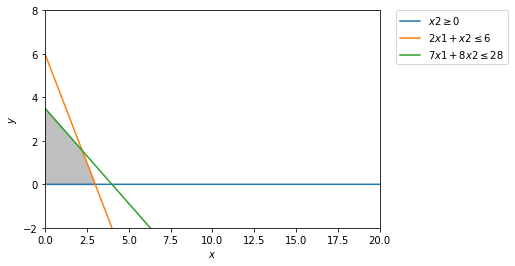

In [ ]:
# First each of the constraints is defined as a line 
# Then we shade the area of the feasible solutions

# Construct lines
# x1 > 0
x1 = np.linspace(0, 20, 2000)#making 2000 points between 0 and 20
# x2 >= 0
y1 = (x1*0) 
# 2x1 + x2 <= 6
y2 = (6-2*x1)
# 7x1 + 8x2 <= 28 
y3 = (28-7*x1)/8.0


# Show the lines plots

plt.plot(x1, y1, label=r'$x2\geq0$')
plt.plot(x1, y2, label=r'$2x1 + x2 \leq 6$')
plt.plot(x1, y3, label=r'$7x1 +8x2 \leq 28$')
#Defining limits of the plot
plt.xlim((0, 20))
plt.ylim((-2, 8))
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

# Determine the feasible region and fill it
# First, we create two "horizontal lines"  y5 and y6 that delimit the polygonon
y5 = np.minimum(y2, y3)
y6 = np.maximum(y1, y1)

# The function "fill_between" shades an area delimited by two horizontal curves)
plt.fill_between(x1,y5, y6, where=y5>y6, color='grey', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Defining and solving the problem using pulp

In [ ]:
# We define the problem as of maximization

transformers_lp_problem = pulp.LpProblem("Transformer production LP problem", pulp.LpMaximize)

# Variables x1 and x2 are defined and their lower bounds are set according to the constraints x1,x2>=0 and integer
#category can be: binary, integer or countinous, in this case, we choose integer
X1 = pulp.LpVariable('X1', lowBound=0, cat='Integer')
X2 = pulp.LpVariable('X2', lowBound=0, cat='Integer')

# Objective function
transformers_lp_problem += 120000 * X1 + 80000 * X2, "z"

# Constraints
transformers_lp_problem += 2*X1 + X2 <= 6
transformers_lp_problem += 7*X1 + 8*X2 <= 28

# Visualization of the model
transformers_lp_problem   

/usr/local/lib/python3.6/dist-packages/pulp/pulp.py:1198: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Transformer_production_LP_problem:
MAXIMIZE
120000*X1 + 80000*X2 + 0
SUBJECT TO
_C1: 2 X1 + X2 <= 6

_C2: 7 X1 + 8 X2 <= 28

VARIABLES
0 <= X1 Integer
0 <= X2 Integer

In [ ]:
# The solver is invoked, will solve it if the function is feasible
transformers_lp_problem.solve()

# The status of the solver is shown
print("The status of the solution found is: ", pulp.LpStatus[transformers_lp_problem.status])

# The optimal values for each of the variables are displayed
print("The optimal values for the variables are: ")
for variable in transformers_lp_problem.variables():
    print ("{} = {}".format(variable.name, variable.varValue))

# The best solution is printed    
print("Optimal value: ",pulp.value(transformers_lp_problem.objective))

The status of the solution found is:  Optimal
The optimal values for the variables are: 
X1 = 3.0
X2 = 0.0
Optimal value:  360000.0


### Results

Optimal solution: X1 = 3 and X2 = 0.
To maximize the revenue, there will be produced 3 transformers of type 1 and 0 of type 2.

Optimal value: 360000. The revenue obtained by selling those 3 transformers of type 1 will be 360000 Eurodolars.

### Graphical representation of the optimal solution

Now that we have the optimal solution, we can plot the optimal solution as part of the feasible set of solutions

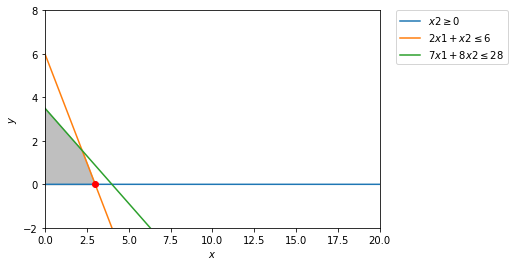

In [ ]:
# Show the lines plots

plt.plot(x1, y1, label=r'$x2\geq0$')
plt.plot(x1, y2, label=r'$2x1 + x2 \leq 6$')
plt.plot(x1, y3, label=r'$7x1 +8x2 \leq 28$')
#Defining limits of the plot
plt.xlim((0, 20))
plt.ylim((-2, 8))
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

# Determine the feasible region and fill it
# First, we create two "horizontal lines"  y5 and y6 that delimit the polygonon
y5 = np.minimum(y2, y3)
y6 = np.maximum(y1, y1)

# The function "fill_between" shades an area delimited two horizontal curves)
plt.fill_between(x1,y5, y6, where=y5>y6, color='grey', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#Plot the optimal point
plt.plot(transformers_lp_problem.variables()[0].varValue,transformers_lp_problem.variables()[1].varValue,'ro')

plt.show()

As we can see in the graph, the optimal solution is one of the corners of the feasible region. Even though it's an integer model and the corners do not necessarily have to be optimal, we still can tell that is inside the feasible region and thus, its a feasible solution. 